** **GAN (Generative Adversarial Network) :**H


The GAN (acronym which stands for Generative Adversarial Network) are artificial neural networks able to generate new contents, so that these results are "likely" compared to a pre-existing dataset. In other words, a GAN can be used to "mimic" the generation of content that is typically done by a human.
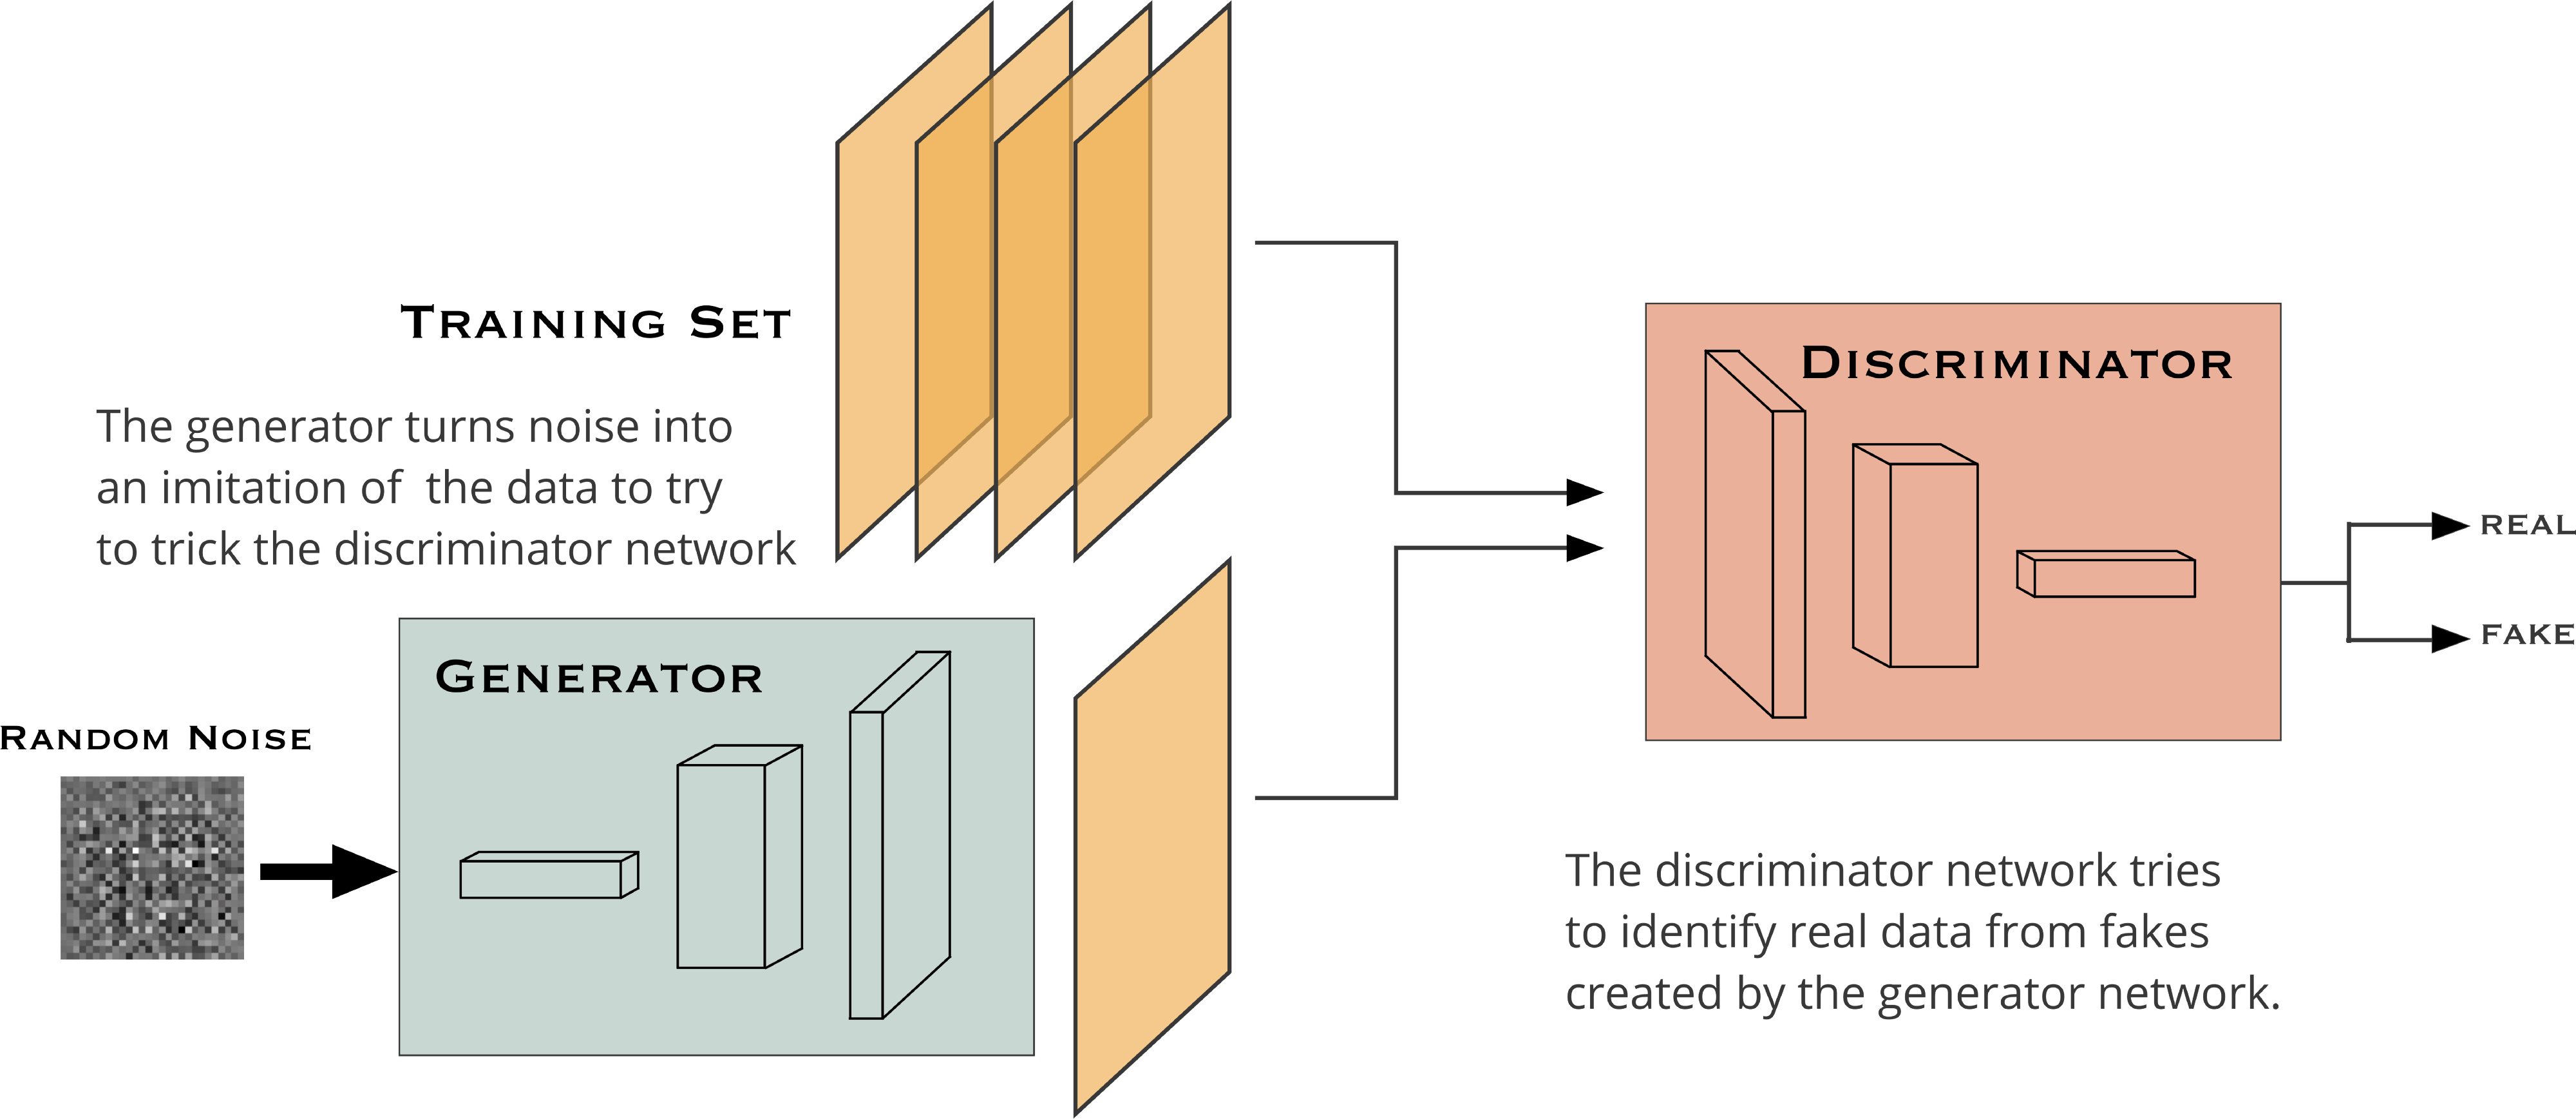

Here we will use Pokemon dataset in this gan network.

Firstly we will load and prepar our data , then train the GAN network after implementing the generator and discriminator.

In [1]:
#import the used libraries and modules
import os # Handle working with files and directories
import numpy as np
import pandas as pd
import tensorflow as tf # Loading images, storing them in tensors
import cv2
import PIL
from PIL import Image
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import matplotlib.pyplot as plt

In [2]:
#contect to my drive to git data from it, we use drive for permanent saving of our data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load and Prepare Dataset :**

In [3]:
#Git the path of our dataset
dataset = '/content/drive/MyDrive/Dataset'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


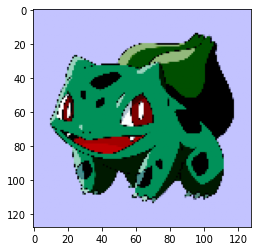

In [4]:
#Firstly we  convert our images  to a jpeg "we can deal with png withou converting"
#The aim of this converting is that the png has no artifacts 
#but jpeg get better compression & adds artifacts trained and expected by the model

def convertToJpg(img_path):
    # Convert png to jpeg
    img = Image.open(img_path)
    if img.mode == 'RGBA':
        img.load()
        background = Image.new("RGB", img.size, (225,225,255))
        background.paste(img, mask=img.split()[3])
        img = np.array(background)
    else:
        img = img.convert('RGB')
        img = np.array(img)
    
    return img
        
# Resize img to 128x128
def resizeImg(img):
    img = cv2.resize(img, (128,128))
    return img

# Normalize pixel values from -1 to 1
def normalizeImg(img):
    img = img / 127.5 - 1
    return img

#Take an image, convert to jpeg, resize if needed and normalize
def openConvert(img_path):
    # Img.png
    if img_path[-4:] == '.png':
        img = convertToJpg(img_path)
    # Img.jpeg
    else:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)

    img = resizeImg(img)
    
    img = normalizeImg(img)
    
    return img

#Sample Test
img = openConvert('/content/drive/MyDrive/Dataset/Bulbasaur/00000000.png')
plt.imshow(img)
plt.show()

In [5]:
#for our training dataset we want to take the images with its labels to train
#Make a list of images and labels
images = []
labels = []

#Number of images per pokemon to load
images_per_pokemon = 10

# Record the current iteration
count = 0
#Through each pokemon folder iterate to save image with its label 
for pokemon in os.listdir(dataset):
    pokemon_dir = os.path.join(dataset, pokemon)
    
    #Count of the number of images loaded for this pokemon
    curr_imgs = 0
    
    #Adding each image to the list
    for img in sorted(os.listdir(pokemon_dir)):
        #Then add image and label to list
        try:
            images.append(openConvert(os.path.join(pokemon_dir, img)))
            labels.append(pokemon)
        except (ValueError, OSError):
            continue
        count += 1
        if count % 1000 == 0:
            print('Current iteration: ' + str(count))
            
        # Increment the no. of images loaded and stop when reach to the saved images for each pokemon
        curr_imgs += 1
        if curr_imgs >= images_per_pokemon:
            break

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


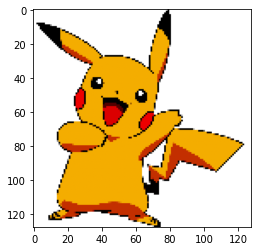

In [6]:
#Sample Test
plt.imshow(images[1])
plt.show()

In [7]:
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, AveragePooling2D, Reshape, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ReduceLROnPlateau

In [8]:
#Print imgae after resizing and determine no. of samples entered the generator as input
image_shape = (images[0].shape)
input_dim = 100   #no. of input features = diminsion of input layer "samples"
print(image_shape)
# the printed tuple of (128,128,3) represents the size of the image and 3 : RGB

(128, 128, 3)


Generator Model:

In [9]:
#In this simple GAN is a simple fully connected network. 
def make_genenerator():

    gen = tf.keras.Sequential() #Seqential allow us to add layes to our network

#Dense layer : take the input (random seed "noise") and does upsampling to get the output and apply this below operation to get the output
  #output = activation(dot(input,kernel)+bias)

#The dense layers acts as hidden layes in our network  
    gen.add(Dense(256, input_dim=input_dim))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())

    gen.add(Dense(512))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())

    gen.add(Dense(1024))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())
    
    gen.add(Dense(np.prod(image_shape), activation='tanh')) # product of all elements then apply the activation
    gen.add(Reshape(image_shape))

    gen.summary()
    #take the input noise to enter the generator
    noise = Input(shape=input_dim,)
    img = gen(noise)
    
    return Model(noise, img)
    

Discriminator Model: 

In [10]:
def make_discriminator():
    disc = tf.keras.Sequential()

    disc.add(Conv2D(128, (3, 3), strides=(2, 2), input_shape=image_shape))
    disc.add(LeakyReLU(alpha=0.2))

#Downsamples the input along its spatial dimensions (height and width) by taking the average value over an input window
#(of size defined by pool_size ) for each channel of the input.
    disc.add(AveragePooling2D(pool_size = (4, 4)))
    disc.add(Flatten())

    disc.add(Dense(units=512, activation='relu'))

#we use sigmoid activation here since our desired ouput is 0 "fake" or 1 "real"
    disc.add(Dense(units=1, activation='sigmoid'))
    
    disc.summary()
    
    img = Input(shape=image_shape)
    check = disc(img) #if zero or one
    
    return Model(img, check)

In [11]:
#firstly build the discriminator then compile it with the model

discriminator = make_discriminator() # here we do an object from discriminator model

#In every epoch we train disc. let it be better,and then train GAN that include generator and disc.,
#it means that use better disc. to update gene.'s weights.
#In other words,gene. have to use disc. to know how fake or how real between fake data and real data.
#gene. can't training alone so compile disc. and GAN

#So, we need to compile these models. The generator will only be trained through the gan model,
 #so we do not need to compile it at all.
#but,the discriminator should not be trained during the second phase"train of generator",
 #so we make it non-trainable before compiling the gan model:

discriminator.compile(loss='binary_crossentropy',
             optimizer=Adam(0.0002,0.5),
             metrics=['accuracy'])

generator = make_genenerator()

z = Input(shape=(input_dim,)) # Noise that generator use to generate the fake images
img = generator(z)

discriminator.trainable = False

check = discriminator(img)

#Comined represent the GAN combined model of the two models gene. and disc.

Combined = Model(z, check)
Combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

#Adam is a replacement optimization algorithm for SGD for training deep learning models.
#It's provide an optimization algorithm that can handle sparse gradients on noisy problems
 # using adam optimizer with 0.0002 learning rate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 63, 63, 128)       0         
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 128)      0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 512)               14746112  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [12]:
batch_size = 128
epochs = 50
sample_interval = 1000
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

These three blocks below is to display the images that generateor creates as it trains :

In [13]:
def show_images(epoch):
    r, c = 4, 4                 #grid of imgs
    noise = np.random.normal(0, 1, (r * c, input_dim))

    gen_imgs = generator.predict(noise)
    #rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    #display the images 
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1

    plt.show()


In [14]:
def show_big_images(epoch):
    noise = np.random.normal(0, 1, (5, input_dim))
    
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

        
    # Show 5 images
    for i in range(5):
        plt.imshow(gen_imgs[i, :, :, :])
        plt.show()

0 [Discriminator loss: 0.728386, acc.: 16.80%] 
 [Generator loss: 0.512869]


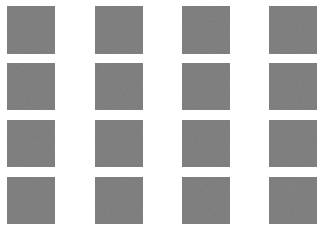

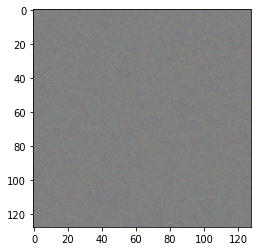

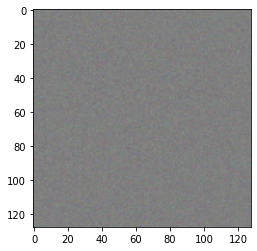

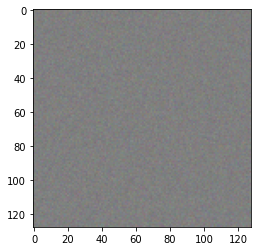

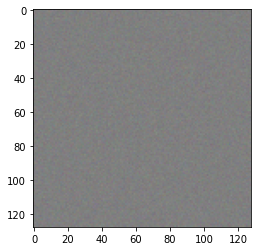

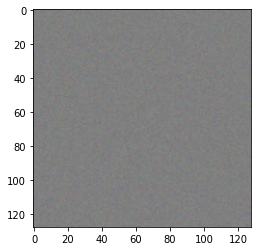

In [15]:
for epoch in range(epochs):
    no = np.random.randint(0, len(images), batch_size)
    imgs = np.array([images[j] for j in no])
    
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    
    gen_imgs = generator.predict(noise)
    
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, input_dim))

    g_loss = Combined.train_on_batch(noise,real)
    
    if epoch % sample_interval == 0:
      #Print the Discriminator and Generator Loses:
        print("%d [Discriminator loss: %f, acc.: %.2f%%] \n [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        show_images(epoch)
        show_big_images(epoch)

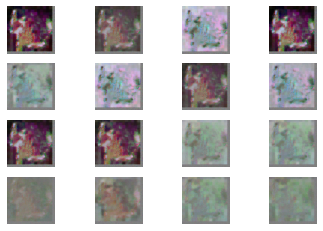

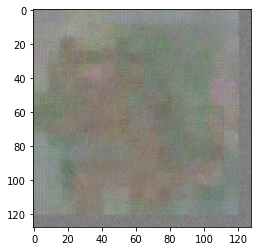

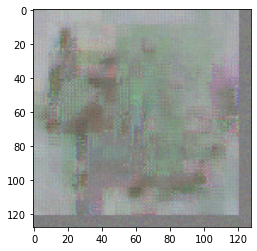

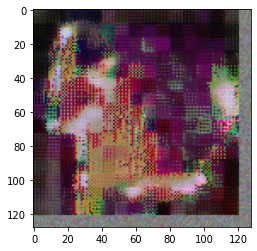

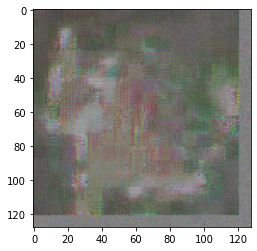

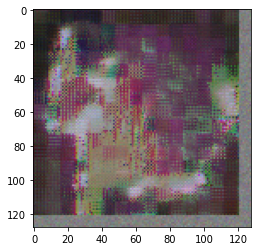

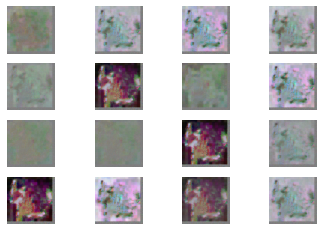

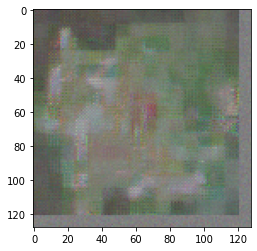

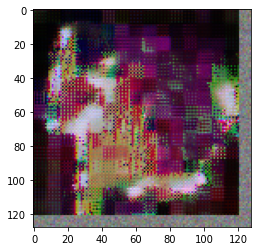

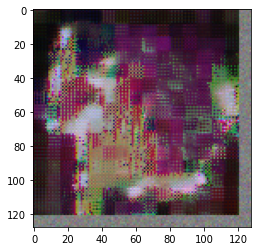

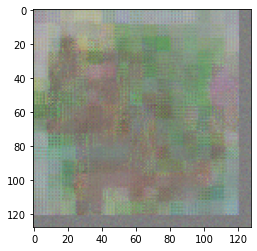

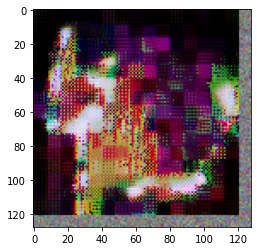

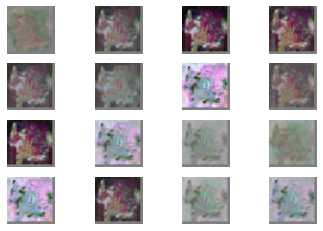

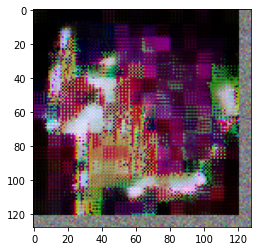

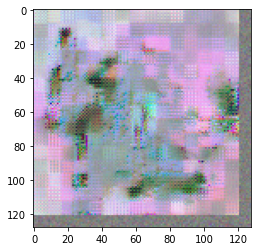

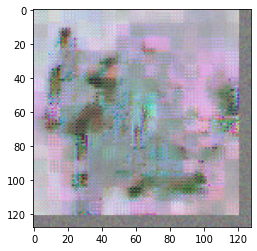

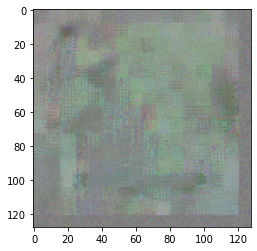

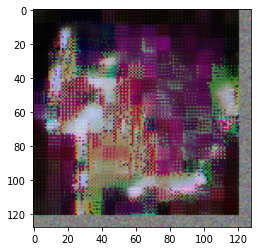

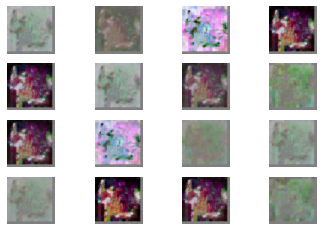

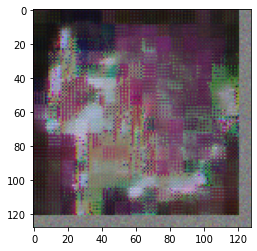

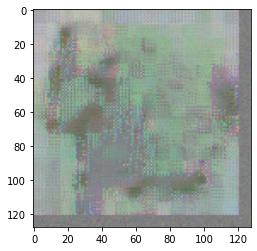

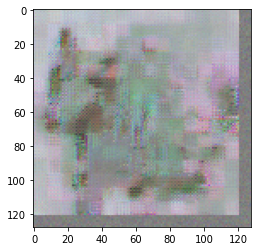

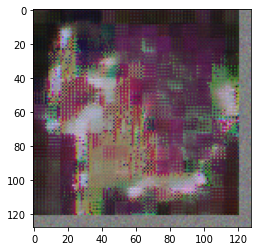

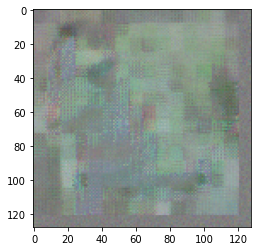

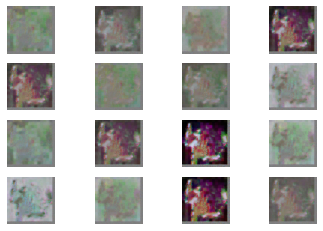

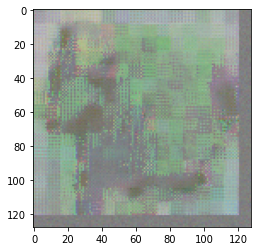

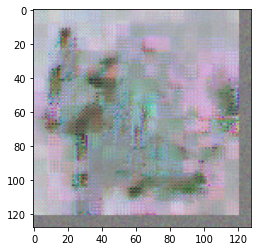

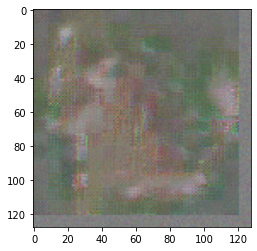

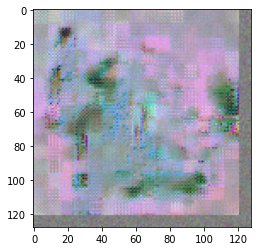

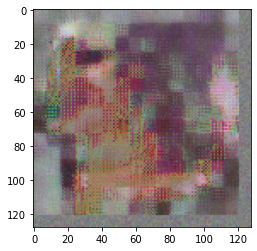

In [16]:
for i in range(5):
    show_images(epoch)
    show_big_images(epoch)
   

**GAN Evaluation by Inception Score (IS):**

The formula of inception score is:
The goal is : Measures the properties of high classifiability and diversity for samples.

It use the conditional label distribution, the formula is as the below figure shows:
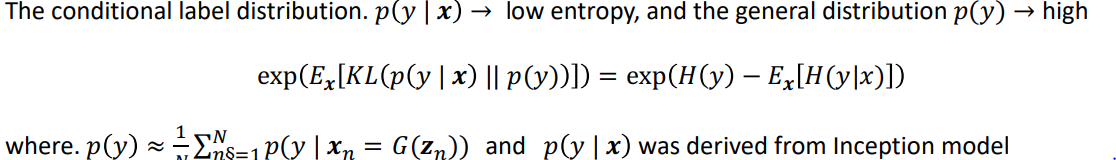

In [17]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy import asarray
from numpy.random import shuffle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm
from skimage.transform import resize


In [18]:
#Calculate the inception score
#Firstly resize the images to new size to fit inception model
#Source Code : https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/

def scaleImages(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)



#the calculate_inception_score() function below takes an array of images with the expected size and pixel values in [0,255] and
#calculates the average and standard deviation inception scores using the inception v3 model in Keras

def calculate_IS(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()        #The model expects images to be color and to have the shape 299×299 pixels.

# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)

	for i in range(n_split):
		#retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		subset = subset.astype('float32')
		subset = scaleImages(subset, (299,299,3)) # to fit the model
		#pre-process images, scale to [-1,1]
		subset = preprocess_input(subset)
	
		# predict p(y|x)
		p_yx = model.predict(subset)
	
		#calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
	
		#calculate KL divergence using log probabilities
		#Where KL:measure of how similar/different two probability distributions are
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		#sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg,is_std = mean(scores), std(scores)
	return is_avg, is_std

images= gen_imgs
shuffle(images)
print('loaded', images.shape)

# calculate inception score
is_avg, is_std = calculate_IS(images)
print('score', is_avg, is_std)   
 



loaded (128, 128, 128, 3)
96124928/96112376 [==============================] - 1s 0us/step
score 1.0202965 0.0092226155


**Fitchet Inception Distance :**

The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.
FID formula:




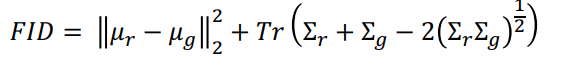 

In [19]:
#Calculate the Frechet Inception Distance with keras
#As in IS we will call the scaleImage function to resize the images to fit the model
#Source Code: https://machinelearningmastery.com
 
def calculate_FID(model, images1, images2):

	#Calculate activations for  the 2 images
	activation1 = model.predict(images1)
	activation2 = model.predict(images2)
 
	#Calculate mean and sigma
	mean1, sigma1 = activation1.mean(axis=0), cov(activation1, rowvar=False)
	mean2, sigma2 = activation2.mean(axis=0), cov(activation2, rowvar=False)
 
	#Calculate sum squared difference between means
	sum_squared_diff = numpy.sum((mean1 - mean2)**2.0)

	#Calculate sqrt of product between cov
	cov_mean = sqrtm(sigma1.dot(sigma2))
 
	#Check and correct imaginary numbers from sqrt
	if iscomplexobj(cov_mean):
		cov_mean = cov_mean.real

	#Calculate score
	fid = sum_squared_diff + trace(sigma1 + sigma2 - 2.0 * cov_mean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

images1 = fake
images2 = real
shuffle(images1)
#reduce the traing set just to not consume time
images1 = images1[:1000]
print('Loaded', images1.shape, images2.shape)

#Convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

#Call scale function to resize images
images1 = scaleImages(images1, (299,299,3))
images2 = scaleImages(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

#Pre-process images to tune its size to fit the inception model
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# calculate fid
fid = calculate_FID(model, images1, images2)
print('FID: %.3f' % fid)


87924736/87910968 [==============================] - 0s 0us/step
Loaded (128, 1) (128, 1)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 0.431
